# Scaling efficiency (using tau data)

## Methodology

The formula used to compute the scaling efficiency is as follows: `t2 / (N*tN)`. Where `tN` is the time needed to process 1 epoch (1.000.000 images) using N GPU.
`tN` is computed using the following formula: `N * GPUs_per_node * batch_size * number_of_batches`

## Issues

The 1 node (1 and 2 GPUs) experiments are taking longer than expected and this is messing the efficiencies.
The efficiencies presented use the 1 GPU experiment as the baseline, the exact values should not be trusted, only the relative (between configurations) trends of the curves.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib

In [2]:
df_interval = pd.read_parquet('data/mpi/interval.gzip')
df_interval

,run,nodes,gpus_per_node,network_backend,profile_level,workers,neural_network,data_loader,batch_size_per_gpu,grad_precision,compute_precision,gpu,thread,function,calls,subcalls,exc_time,inc_time
0,0,1,1,ib,tau_exec,2,resnet50,dali-cpu-to-gpu,32,fp16,fp32,0,0,.tau application,1,35,88005914,88529151
1,0,1,1,ib,tau_exec,2,resnet50,dali-cpu-to-gpu,32,fp16,fp32,0,0,pthread_create,22,0,698,698
2,0,1,1,ib,tau_exec,2,resnet50,dali-cpu-to-gpu,32,fp16,fp32,0,0,pthread_join,13,0,522539,522539
3,0,1,1,ib,tau_exec,2,resnet50,dali-cpu-to-gpu,32,fp16,fp32,0,1,.tau application,1,10978,-260151,0
4,0,1,1,ib,tau_exec,2,resnet50,dali-cpu-to-gpu,32,fp16,fp32,0,1,mpi_allgather,2,0,46,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3059835,9,58,2,ib,tau_exec,8,resnet50,dali-gpu,64,fp32,fp32,115,44,.tau application,1,0,93002793,93002793
3059836,9,58,2,ib,tau_exec,8,resnet50,dali-gpu,64,fp32,fp32,115,45,.tau application,1,0,92958716,92958716
3059837,9,58,2,ib,tau_exec,8,resnet50,dali-gpu,64,fp32,fp32,115,46,.tau application,1,0,0,0
3059838,9,58,2,ib,tau_exec,8,resnet50,dali-gpu,64,fp32,fp32,115,47,.tau application,1,0,0,0


In [3]:
# select configurations

def configurations():
    '''
    Return a generator of all the configurations. Each configuration is a list of strings.
    '''
#     num_nodes = [1, 8, 16, 32, 48, 58]
#     gpus_per_node = [2]
    network_backend = ['ib']
    profile_level = ['tau_exec']
    workers = [2, 8]
    neural_network = ['resnet50']
    data_loader = ['dali-gpu', 'dali-cpu-to-gpu']
    batch_size_per_gpu = [32, 64]
    grad_precision = ['fp16', 'fp32']
    compute_precision = ['fp32']
    
    def to_str(l):
        return [str(elem) for elem in l]

    confs = [
#             to_str(num_nodes),
#             to_str(gpus_per_node),
            network_backend,
            profile_level,
            to_str(workers),
            neural_network,
            data_loader,
            to_str(batch_size_per_gpu),
            grad_precision,
            compute_precision
            ]
    
    return itertools.product(*confs)

In [4]:
def median_duration_epoch(df, node, gpus_per_node, batch_size, init_time):
    '''
    Return the median duration of 1 epoch for the 10 runs of the experiment
    '''
    durations_epoch = []
                
    total_img_processed = node * int(gpus_per_node) * int(batch_size) * 50
    for run in range(10):

        duration = df[
            (df['gpus_per_node'] == int(gpus_per_node)) & 
            (df['nodes'] == node) & 
            (df['run'] == run)
        ]['inc_time']

        duration = np.max(duration) * 1E-6 # convert to seconds
        duration -= init_time # substract initialization time
        duration_epoch = duration * 1E6 / total_img_processed # 1 million images per epoch

        durations_epoch.append(duration_epoch)

    median_duration_epoch = np.median(durations_epoch)
    return median_duration_epoch

In [5]:
def scaling_efficiencies(d):
    '''
    Return 2 lists:
    - all the numbers of GPUs used
    - the scaling efficiency for the corresponding number of GPUs
    '''
    gpus = []
    efficiencies = []
    for gpu, t in d.items():
        if gpu == 2: 
            efficiencies.append(100)
#             continue
        else: efficiencies.append(d[2] / (gpu * t)*100)
        gpus.append(gpu)
    return gpus, efficiencies

In [6]:
def plot_scaling_efficiencies(ax, gpus, efficiencies, title, save=False):
    ax.scatter(gpus, efficiencies, linewidth=4)
    ax.plot(gpus, efficiencies, linestyle='--', linewidth=4)
    ax.set_ylim(45, 105)
    ax.set_xscale('log')
    ax.set_xticks(gpus)  
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.grid('--')
    ax.set_ylabel('Scaling efficiency (%)', fontsize=30)
    ax.set_xlabel('Number of GPUs', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.set_title(title, fontsize=30)
    if save:
        plt.savefig(title, bbox_inches='tight')

In [7]:
df_init_times = pd.read_parquet('data/mpi/batch1_5runs_interval.gzip')

def get_init_time(config):
    nodes, gpus, network, profile, workers, nn, data_loader, batch_size, grad, compute = config
    
    init = df_init_times[
        (df_init_times['nodes'] == int(nodes)) & 
        (df_init_times['workers'] == int(workers)) & 
        (df_init_times['data_loader'] == data_loader) & 
        (df_init_times['batch_size_per_gpu'] == int(batch_size)) & 
        (df_init_times['grad_precision'] == grad) &
        (df_init_times['gpu'] == 0) &
        (df_init_times['thread'] == 0) &
        (df_init_times['function'] == '.tau application')
    ].inc_time.values
    init_time = np.median(init) * 1E-6 # in seconds
    return init_time

ib tau_exec 2 resnet50 dali-gpu 32 fp16 fp32
ib tau_exec 2 resnet50 dali-gpu 32 fp32 fp32
ib tau_exec 2 resnet50 dali-gpu 64 fp16 fp32
ib tau_exec 2 resnet50 dali-gpu 64 fp32 fp32
ib tau_exec 2 resnet50 dali-cpu-to-gpu 32 fp16 fp32
ib tau_exec 2 resnet50 dali-cpu-to-gpu 32 fp32 fp32
ib tau_exec 2 resnet50 dali-cpu-to-gpu 64 fp16 fp32
ib tau_exec 2 resnet50 dali-cpu-to-gpu 64 fp32 fp32
ib tau_exec 8 resnet50 dali-gpu 32 fp16 fp32
ib tau_exec 8 resnet50 dali-gpu 32 fp32 fp32
ib tau_exec 8 resnet50 dali-gpu 64 fp16 fp32
ib tau_exec 8 resnet50 dali-gpu 64 fp32 fp32
ib tau_exec 8 resnet50 dali-cpu-to-gpu 32 fp16 fp32
ib tau_exec 8 resnet50 dali-cpu-to-gpu 32 fp32 fp32
ib tau_exec 8 resnet50 dali-cpu-to-gpu 64 fp16 fp32
ib tau_exec 8 resnet50 dali-cpu-to-gpu 64 fp32 fp32


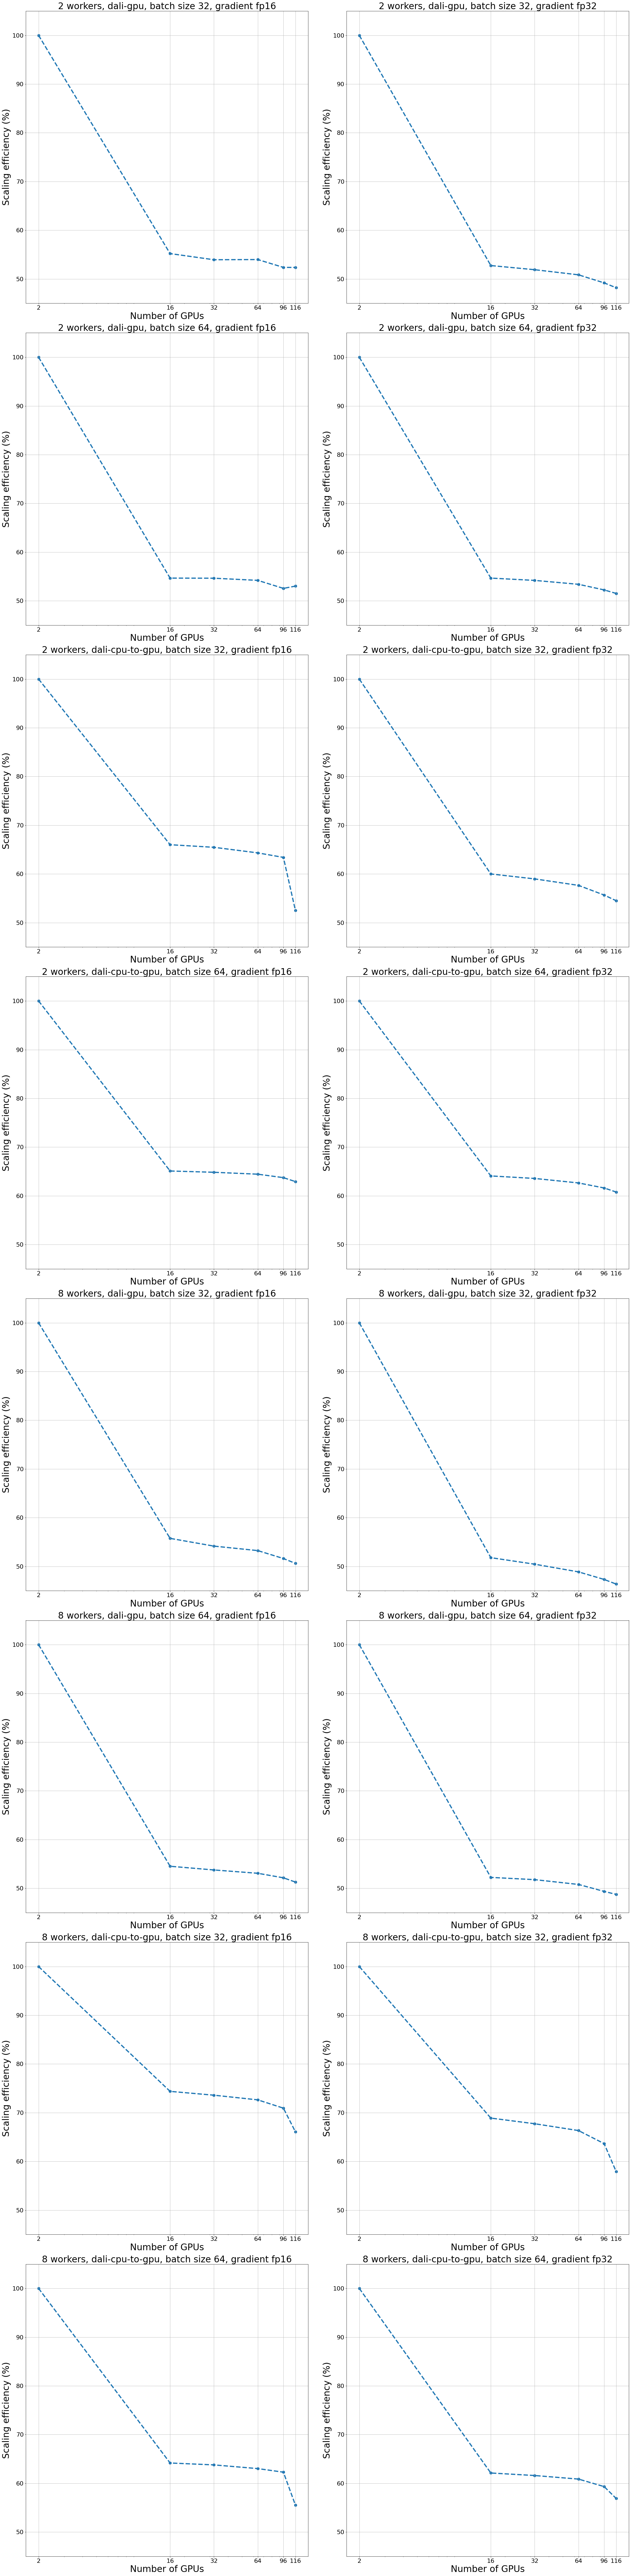

In [8]:
f = plt.figure(dpi= 80, facecolor='w', edgecolor='k')
f.set_figheight(120)
f.set_figwidth(30)
for i, conf in enumerate(configurations()):
    ax = f.add_subplot(8, 2, i+1)
    
    network_backend, profile_level, workers, nn, data_loader, batch_size, grad, compute = conf

    print(network_backend, profile_level, workers, nn, data_loader, batch_size, grad, compute)
    
    mask_config = \
        (df_interval['network_backend'] == network_backend) & \
        (df_interval['profile_level'] == profile_level) & \
        (df_interval['workers'] == int(workers)) & \
        (df_interval['neural_network'] == nn) & \
        (df_interval['data_loader'] == data_loader) & \
        (df_interval['batch_size_per_gpu'] == int(batch_size)) & \
        (df_interval['grad_precision'] == grad) & \
        (df_interval['compute_precision'] == compute) & \
        (df_interval['function'] == '.tau application')
    
    df_config = df_interval[mask_config]
    
    d = {} # map number of GPUs to the duration of 1 epoch
    
    for node in [1, 8, 16, 32, 48, 58]:
        gpus_per_node = 2 # experiments always use 2 GPUs per node
        
        # Set initialization time
        init_time = get_init_time((node if node<=32 else 32, gpus_per_node, *conf))
        
        d[node * gpus_per_node] = median_duration_epoch(df_config, node, gpus_per_node, batch_size, init_time)
    
    gpus, efficiencies = scaling_efficiencies(d)
    
    title = f'{workers} workers, {data_loader}, batch size {batch_size}, gradient {grad}'
    plot_scaling_efficiencies(ax, gpus, efficiencies, title, save=True)
plt.tight_layout()
